In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

## Paths

In [2]:
data_dir = "/home/nikhil/projects/brain_changes/data/ukbb/"

tab_follow_up_csv = f"{data_dir}tabular/tab_follow_up.csv"
brain_age_ses2_p1_csv = f"{data_dir}/results/brain-age_ukbb-followup_ses-2_p1_SFCN-run-1_results.csv"
brain_age_ses2_p2_csv = f"{data_dir}/results/brain-age_ukbb-followup_ses-2_p2_SFCN-run-1_results.csv"
brain_age_ses3_csv = f"{data_dir}/results/brain-age_ukbb-followup_ses-3_SFCN-run-1_results.csv"


## Read results

In [3]:
ukbb_tab_followup_df = pd.read_csv(tab_follow_up_csv)
ukbb_tab_followup_df = ukbb_tab_followup_df.reset_index()
brain_age_ses2_p1_df = pd.read_csv(brain_age_ses2_p1_csv)
brain_age_ses2_p2_df = pd.read_csv(brain_age_ses2_p2_csv)

brain_age_ses2_df = brain_age_ses2_p1_df.append(brain_age_ses2_p2_df)
brain_age_ses2_df = brain_age_ses2_df.rename(columns={"pred":"pred_at_ses2", "prob":"prob_at_ses2"})
brain_age_ses2_df = brain_age_ses2_df.drop(columns=["Unnamed: 0"])

brain_age_ses3_df = pd.read_csv(brain_age_ses3_csv)
brain_age_ses3_df = brain_age_ses3_df.rename(columns={"pred":"pred_at_ses3", "prob":"prob_at_ses3"})
brain_age_ses3_df = brain_age_ses3_df.drop(columns=["Unnamed: 0"])

brain_age_ses2_success = list(brain_age_ses2_df.index)
brain_age_ses3_success = list(brain_age_ses3_df.index)

print(f"Number of successful predictions\n ses-2: {len(brain_age_ses2_success)}, ses-3: {len(brain_age_ses3_success)}")

brain_age_df = pd.merge(brain_age_ses2_df, brain_age_ses3_df, on="eid", how="inner")
brain_age_df = pd.merge(brain_age_df, ukbb_tab_followup_df, on="eid", how="left")
brain_age_df["scan_interval"] = brain_age_df["age_at_ses3"] - brain_age_df["age_at_ses2"]

print(f"Number of brain-age subjects: {len(brain_age_df)}")

brain_age_df.head()

Number of successful predictions
 ses-2: 3044, ses-3: 3065
Number of brain-age subjects: 2933


,eid,pred_at_ses2,prob_at_ses2,pred_at_ses3,prob_at_ses3,index,sex,birth_year,T1-ses2,T1-ses3,ethnicity,age_at_ses2,age_at_ses3,age_at_recruitment,scan_interval
0,1004084,66.834612,[0.00090773 0.00093408 0.00098936 0.00085202 0...,68.104931,[0.00107993 0.00113779 0.00132602 0.00138609 0...,1,1.0,1947.0,20252_2_0,20252_3_0,1001.0,70.0,72.0,60.0,2.0
1,1010063,52.458433,[2.85410097e-05 4.52067616e-05 2.40045178e-04 ...,53.228092,[2.9535762e-05 4.5728742e-05 2.2089168e-04 2.0...,3,0.0,1964.0,20252_2_0,20252_3_0,1001.0,53.0,55.0,45.0,2.0
2,1014782,61.505157,[2.0425497e-04 2.2044049e-04 2.6866587e-04 2.3...,66.927790,[0.00119282 0.00128485 0.0016164 0.00184236 0...,9,1.0,1947.0,20252_2_0,20252_3_0,1001.0,70.0,72.0,61.0,2.0
3,1016215,65.544100,[2.03753036e-04 2.05709584e-04 1.98428897e-04 ...,68.055118,[2.04080905e-04 2.08782920e-04 2.15765467e-04 ...,10,1.0,1951.0,20252_2_0,20252_3_0,1001.0,65.0,67.0,56.0,2.0
4,1022531,65.136880,[0.00093911 0.00100203 0.00120763 0.001233 0...,68.032131,[0.00086184 0.00089053 0.00096467 0.00089484 0...,15,1.0,1951.0,20252_2_0,20252_3_0,1001.0,66.0,68.0,58.0,2.0


## Compute performance

MAE = 4.22 (std = 2.97)
 Pearsons r= (0.8890776358427612, 0.0)
MAE = 4.89 (std = 3.13)
 Pearsons r= (0.8846483054095833, 0.0)


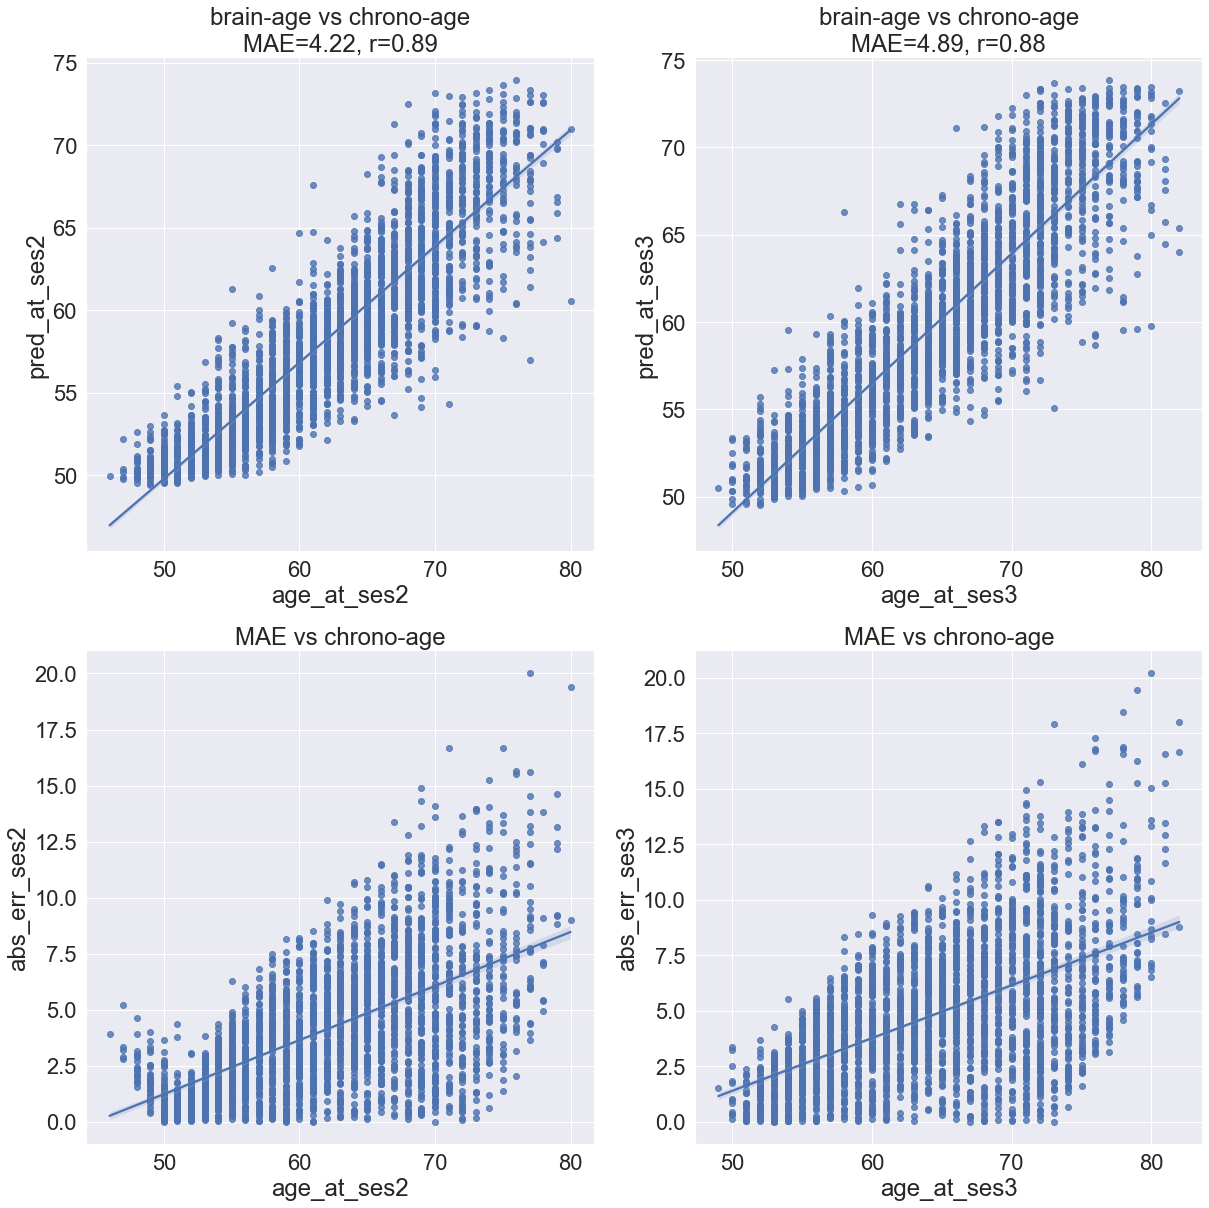

In [4]:
## MAE
palette = 'husl'
sns.set(font_scale=2)

fig, axes = plt.subplots(2,2,figsize=(20,20))
sessions = ["ses2", "ses3"]

plot_df = brain_age_df.copy()
for s, session in enumerate(sessions): 
    y_true = plot_df[f"age_at_{session}"]
    y_pred = plot_df[f"pred_at_{session}"]

    abs_err = np.abs(y_pred - y_true)
    plot_df[f"abs_err_{session}"] = abs_err

    MAE = np.mean(abs_err)
    std_AE = np.std(abs_err)

    corr = stats.pearsonr(y_true, y_pred)
    print(f"MAE = {MAE:3.2f} (std = {std_AE:3.2f})\n Pearsons r= {corr}")

    # Plots
    with sns.axes_style("whitegrid"):    
        ax = axes[0,s]
        g = sns.regplot(x=f"age_at_{session}", y=f"pred_at_{session}", data=plot_df, ax=ax)
        g.set_title(f"brain-age vs chrono-age\nMAE={MAE:3.2f}, r={corr[0]:3.2f}")

        ax = axes[1,s]
        g = sns.regplot(x=f"age_at_{session}", y=f"abs_err_{session}", data=plot_df, ax=ax)
        g.set_title("MAE vs chrono-age")



## Plot ses2 vs ses3 age

number of Benjamine Buttons: 363 (12.38%)
    sex  scan_interval  Brain-age (ses3 - ses2)
0   0.0            1.0                 1.980964
1   1.0            1.0                -0.145154
2   0.0            2.0                 1.382741
3   1.0            2.0                 1.525139
4   0.0            3.0                 1.405279
5   1.0            3.0                 1.566789
6   0.0            4.0                 2.671646
7   1.0            4.0                 2.833668
8   0.0            5.0                 1.733408
9   1.0            5.0                 2.656061
10  0.0            6.0                 3.384764
11  1.0            6.0                 4.062509
12  0.0            7.0                 3.437898
13  1.0            7.0                 2.779541
Brain-age prediction (ses3 - ses2), mean: 1.49 (1.53)


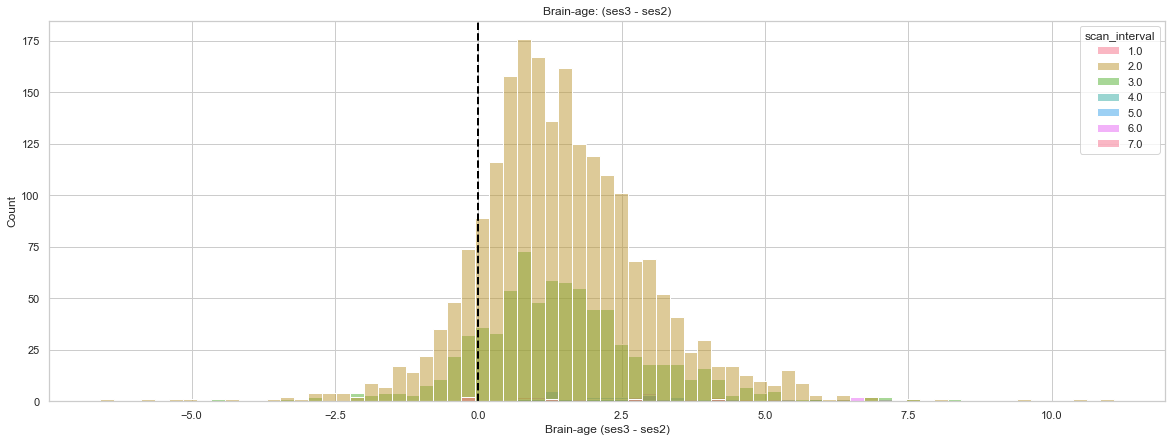

In [11]:
followup_diff = brain_age_df["pred_at_ses3"] - brain_age_df["pred_at_ses2"]
brain_age_df["Brain-age (ses3 - ses2)"] = followup_diff

neg_age_count = np.sum(followup_diff < 0)

print(f"number of Benjamine Buttons: {neg_age_count} ({100*neg_age_count/len(brain_age_df):3.2f}%)")

print(brain_age_df.groupby(["scan_interval","sex"]).mean().reset_index()[["sex","scan_interval","Brain-age (ses3 - ses2)"]])

plot_df = brain_age_df.copy()
m,s = np.mean(plot_df["Brain-age (ses3 - ses2)"]), np.std(plot_df["Brain-age (ses3 - ses2)"])
print(f"Brain-age prediction (ses3 - ses2), mean: {m:3.2f} ({s:3.2f})")

# Plots
with sns.axes_style("whitegrid"): 
    fig,ax=plt.subplots(figsize=(20,7))
    palette = 'husl'
    g = sns.histplot(x="Brain-age (ses3 - ses2)", hue="scan_interval", data=brain_age_df, palette=palette)
    g.set_title(f"Brain-age: (ses3 - ses2)")
    plt.axvline(0, color="black",ls="--",lw=2)

## BBs and associate traits

In [12]:
plot_df = brain_age_df.copy()

with sns.axes_style("whitegrid"):    
        g = sns.regplot(x="age_at_ses2", y="Brain-age (ses3 - ses2)", data=plot_df)
        g.set_title(f"brain-age vs chrono-age\nMAE={MAE:3.2f}, r={corr[0]:3.2f}")

,eid,pred_at_ses2,prob_at_ses2,pred_at_ses3,prob_at_ses3,index,sex,birth_year,T1-ses2,T1-ses3,ethnicity,age_at_ses2,age_at_ses3,age_at_recruitment,scan_interval,Brain-age (ses3 - ses2)
0,1004084,66.834612,[0.00090773 0.00093408 0.00098936 0.00085202 0...,68.104931,[0.00107993 0.00113779 0.00132602 0.00138609 0...,1,1.0,1947.0,20252_2_0,20252_3_0,1001.0,70.0,72.0,60.0,2.0,1.270319
1,1010063,52.458433,[2.85410097e-05 4.52067616e-05 2.40045178e-04 ...,53.228092,[2.9535762e-05 4.5728742e-05 2.2089168e-04 2.0...,3,0.0,1964.0,20252_2_0,20252_3_0,1001.0,53.0,55.0,45.0,2.0,0.769659
2,1014782,61.505157,[2.0425497e-04 2.2044049e-04 2.6866587e-04 2.3...,66.927790,[0.00119282 0.00128485 0.0016164 0.00184236 0...,9,1.0,1947.0,20252_2_0,20252_3_0,1001.0,70.0,72.0,61.0,2.0,5.422634
3,1016215,65.544100,[2.03753036e-04 2.05709584e-04 1.98428897e-04 ...,68.055118,[2.04080905e-04 2.08782920e-04 2.15765467e-04 ...,10,1.0,1951.0,20252_2_0,20252_3_0,1001.0,65.0,67.0,56.0,2.0,2.511018
4,1022531,65.136880,[0.00093911 0.00100203 0.00120763 0.001233 0...,68.032131,[0.00086184 0.00089053 0.00096467 0.00089484 0...,15,1.0,1951.0,20252_2_0,20252_3_0,1001.0,66.0,68.0,58.0,2.0,2.895252
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2928,6016797,54.030524,[7.56379450e-05 1.09007276e-04 4.01691912e-04 ...,58.169652,[2.0897256e-04 2.5218492e-04 4.6971836e-04 8.3...,3194,1.0,1961.0,20252_2_0,20252_3_0,1001.0,55.0,57.0,48.0,2.0,4.139129
2929,6019064,59.618843,[1.4823547e-04 1.7162030e-04 2.7124368e-04 3.5...,61.938729,[1.98718451e-04 2.11696140e-04 2.45875999e-04 ...,3196,1.0,1956.0,20252_2_0,20252_3_0,1001.0,61.0,63.0,51.0,2.0,2.319886
2930,6021700,52.307957,[1.39555386e-05 2.32319308e-05 1.48543259e-04 ...,53.185417,[2.9797578e-05 4.6495443e-05 2.3186854e-04 2.2...,3198,0.0,1961.0,20252_2_0,20252_3_0,1001.0,55.0,58.0,47.0,3.0,0.877460
2931,6022307,55.736869,[2.88515002e-04 3.69821500e-04 8.77678744e-04 ...,55.874286,[0.00039601 0.0004978 0.00110086 0.00283505 0...,3199,0.0,1954.0,20252_2_0,20252_3_0,1001.0,62.0,64.0,55.0,2.0,0.137417


## Sex differences

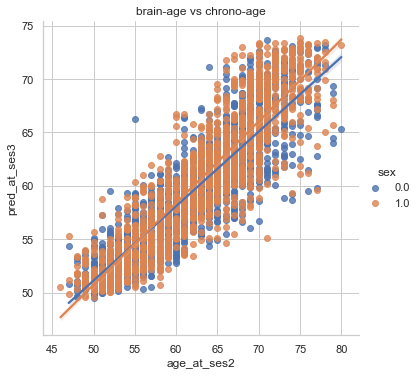

In [7]:
plot_df = brain_age_df.copy()
palette = 'husl'
sns.set(font_scale=1)

with sns.axes_style("whitegrid"):
    g = sns.lmplot(x="age_at_ses2", y=f"pred_at_{session}", hue="sex",data=plot_df)
    plt.title("brain-age vs chrono-age")